## Obspy ground-motion movie using just AuSIS



In [1]:
import obspy
from obspy.clients.fdsn import Client
from obspy.clients.fdsn import RoutingClient
from obspy import UTCDateTime



In [2]:
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth
from matplotlib.transforms import blended_transform_factory

import os

plt.style.use(['seaborn-poster'])


In [3]:
event_name = "Broome6.6"
event_time = obspy.UTCDateTime('2019-07-14T05:39:24')
event_lat = -18.269
event_lon = 120.294
window_start = event_time - 60
window_end = window_start + 20*60
fmin = 0.01
fmax = 0.033
scale = 1.0e4
sample_loc1 = "KNRA"
sample_loc2 = "TOO"

# event_name = "Laiwui7.3"
# event_time = obspy.UTCDateTime('2019-07-14T09:10:50')
# event_lat = -0.53
# event_lon = 128.09
# window_start = event_time + 150 
# window_end   = window_start + 1500
# fmin = 0.001
# fmax = 0.01
# scale=1.0e5
# sample_loc1 = "KNRA"
# sample_loc2 = "TOO"


# event_name = "Fiji7.9"
# event_time = obspy.UTCDateTime('2018-09-06T15:49:18')
# event_lat = -18.47	
# event_lon = 179.35
# window_start = event_time + 60 
# window_end   = window_start + 40*60
# fmin = 0.01
# fmax = 0.033
# scale=1.0e5
# sample_loc1 = "AUDHS"
# sample_loc2 = "AUSIS"


# event_name = "Namatanai7.6"
# event_time = obspy.UTCDateTime('2019-05-14T12:58:25')
# event_lat = -4.05
# event_lon = 152.60
# window_start = event_time + 60 
# window_end   = window_start + 30*60
# fmin = 0.001
# fmax = 0.02
# scale=1.0e5
# sample_loc1 = "AUAYR"
# sample_loc2 = "AUHAR"

# event_name = "Peru8.0"
# event_time = obspy.UTCDateTime('2019-05-26T07:41:15')
# event_lat = -5.81
# event_lon = 360.0-75.27
# window_start = event_time + 1000 
# window_end   = window_start + 70*60
# fmin = 0.015
# fmax = 0.025
# scale=1.0e5
# sample_loc1 = "AUBUS"
# sample_loc2 = "AUTOO"


In [4]:
if not os.path.isdir(event_name):
    os.mkdir(event_name)

In [5]:
iris_client = Client('IRIS')
st_au = iris_client.get_waveforms(network='AU', station='*', location='*',
                                  channel='BHZ,HHZ,BHE,HHE,BHN,HHN', starttime=window_start, endtime=window_end,
                                  attach_response=True)

inv_au = iris_client.get_stations(network="AU",
         channel="*", starttime=window_start,
         endtime=window_end)

station_names_au = inv_au.get_contents()["stations"]

# define a filter band to prevent amplifying noise during the deconvolution (use default example)
pre_filt = (0.005, 0.006, 30.0, 35.0)
st_au.remove_response(output='DISP', pre_filt=pre_filt)


437 Trace(s) in Stream:

AU.ARMA..BHE | 2019-07-14T05:38:24.019538Z - 2019-07-14T05:58:23.994538Z | 40.0 Hz, 48000 samples
...
(435 other traces)
...
AU.YNG.00.BHZ | 2019-07-14T05:38:24.000000Z - 2019-07-14T05:58:24.000000Z | 40.0 Hz, 48001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [6]:
auspass_client = Client('http://auspass.edu.au:80')

st_sis  = auspass_client.get_waveforms(network='S1', station='*', location='*',
                                  channel='BHZ,BHE,BHN', starttime=window_start, endtime=window_end,
                                  attach_response=True)

inv_sis = auspass_client.get_stations(network="AU,S1",
          channel="*", starttime=window_start,
          endtime=window_end)

station_names_sis = inv_sis.get_contents()["stations"]

pre_filt = (0.005, 0.006, 30.0, 35.0)
st_sis.remove_response(output='DISP', pre_filt=pre_filt)


83 Trace(s) in Stream:

S1.AUBRN..BHZ | 2019-07-14T05:38:21.400000Z - 2019-07-14T05:58:39.000000Z | 10.0 Hz, 12177 samples
...
(81 other traces)
...
S1.AUSIS..BHN | 2019-07-14T05:38:12.200000Z - 2019-07-14T05:58:27.500000Z | 10.0 Hz, 12154 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [7]:
st_all = st_au + st_sis
inv_all = inv_au + inv_sis

In [8]:


st2all = st_all.copy()
st2all.filter(type='bandpass',freqmin=fmin,freqmax=fmax)
st2all.merge()

249 Trace(s) in Stream:

AU.FITZ..BHZ | 2019-07-14T05:38:24.000000Z - 2019-07-14T05:58:24.000000Z | 40.0 Hz, 48001 samples (masked)
...
(247 other traces)
...
S1.AUUHS..BHZ | 2019-07-14T05:37:59.600000Z - 2019-07-14T05:58:24.400000Z | 10.0 Hz, 12249 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [9]:
# For this purpose, fragments are not helpful so eliminate them

# for stream in (st2z, st2e, st2n):

#     mean_npoints = 0
#     for t in stream:
#         mean_npoints += t.meta.npts / t.meta.sampling_rate
#     mean_npoints /= len(stream)

#     for t in stream:
#         if t.meta.npts / t.meta.sampling_rate < mean_npoints * 0.5:
#             stream.remove(t)


*Z
*E
*N


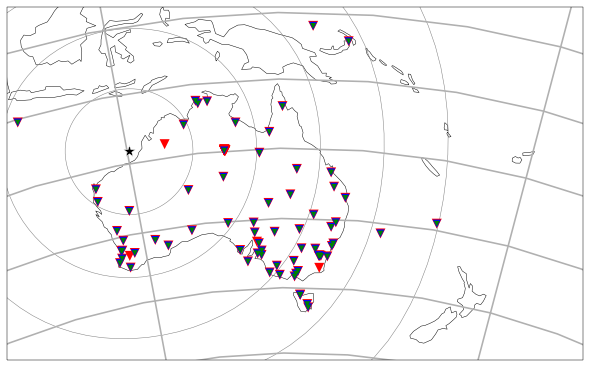

In [10]:
lat = event_lat
lon = event_lon

fig = plt.figure(figsize=(10.0,10.0))
# Define the Cartopy Projection

maxlat = 0.
minlat = -50
maxlon = 190
minlon = 100
lat0 = (maxlat + minlat)/2.0
lon0 = (maxlon + minlon)/2.0
proj_kwargs={}
proj_kwargs['central_latitude'] = lat0
proj_kwargs['central_longitude'] = lon0
proj_kwargs['standard_parallels'] = [lat0,lat0]
proj = ccrs.AlbersEqualArea(**proj_kwargs)
map_ax = fig.add_axes([0.1,0.1,0.8,0.8],projection=proj)
x0, y0 = proj.transform_point(lon0, lat0, proj.as_geodetic())
deg2m_lat = 2 * np.pi * 6371 * 1000 / 360
deg2m_lon = deg2m_lat * np.cos(lat0 / 180 * np.pi)
height = (maxlat - minlat) * deg2m_lat
width = (maxlon - minlon) * deg2m_lon
map_ax.set_xlim(x0 - width / 2, x0 + width / 2)
map_ax.set_ylim(y0 - height / 2, y0 + height / 2)

# Plot the Coastlines
map_ax.coastlines()

# Plot the Parallels and Meridians
map_ax.gridlines()

# Plot the source with a star
map_ax.scatter(lon, lat, marker="*", s=150, zorder=10,
                color="k", edgecolor="w", transform = proj.as_geodetic())

import warnings
warnings.filterwarnings("ignore")

# Plot the station with data with a triangle, and the path source-reciever

colours = ("Red", "Blue", "Green")
sizes = (100, 66, 33)

for i, chan in enumerate(["*Z", "*E", "*N"]):
    print(chan)
    st = st2all.select(channel=chan)
    col = colours[i]
    size = sizes[i]
    
    for net in inv_all:
        for station in net:
            if len(st.select(station=station.code))!=0:
                map_ax.scatter(station.longitude, station.latitude, marker="v", s=size, zorder=10,
                         color=col, edgecolor="none", linewidth=0.25, transform = proj.as_geodetic())
  
map_ax.tissot(lons=event_lon, lats=event_lat, rad_km=1000, edgecolor="grey", facecolor="none", linewidth=0.5 )
map_ax.tissot(lons=event_lon, lats=event_lat, rad_km=2000, edgecolor="grey", facecolor="none", linewidth=0.5 )
map_ax.tissot(lons=event_lon, lats=event_lat, rad_km=3000, edgecolor="grey", facecolor="none", linewidth=0.5 )
map_ax.tissot(lons=event_lon, lats=event_lat, rad_km=4000, edgecolor="grey", facecolor="none", linewidth=0.5 )
map_ax.tissot(lons=event_lon, lats=event_lat, rad_km=5000, edgecolor="grey", facecolor="none", linewidth=0.5 )


In [11]:
t = st2all[0]
t.meta.station

for tr in st2all:
    tr_station = tr.stats.station
    station = inv_all.select(station=tr_station)[0].stations[0]
    tr.stats.coordinates = {}
    tr.stats.coordinates["latitude"]  = station.latitude
    tr.stats.coordinates["longitude"] = station.longitude


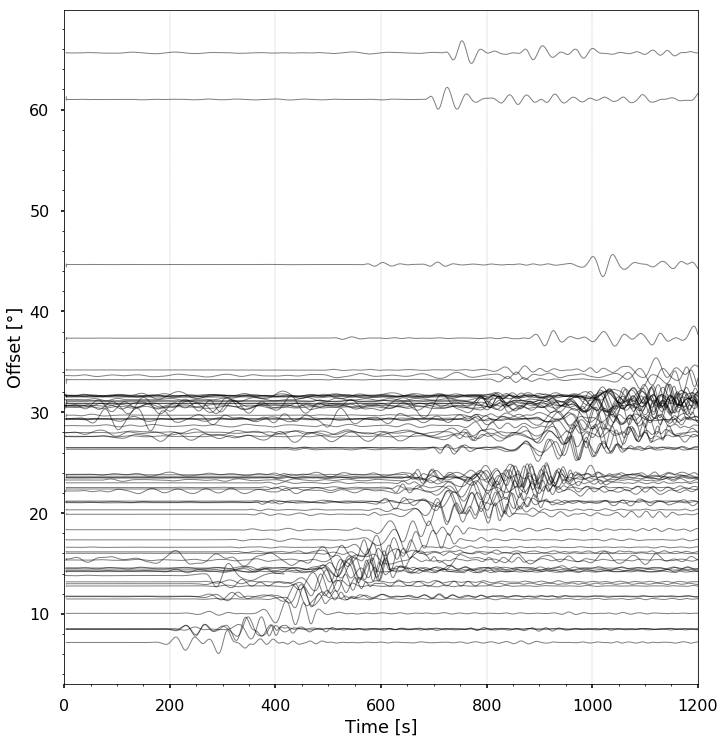

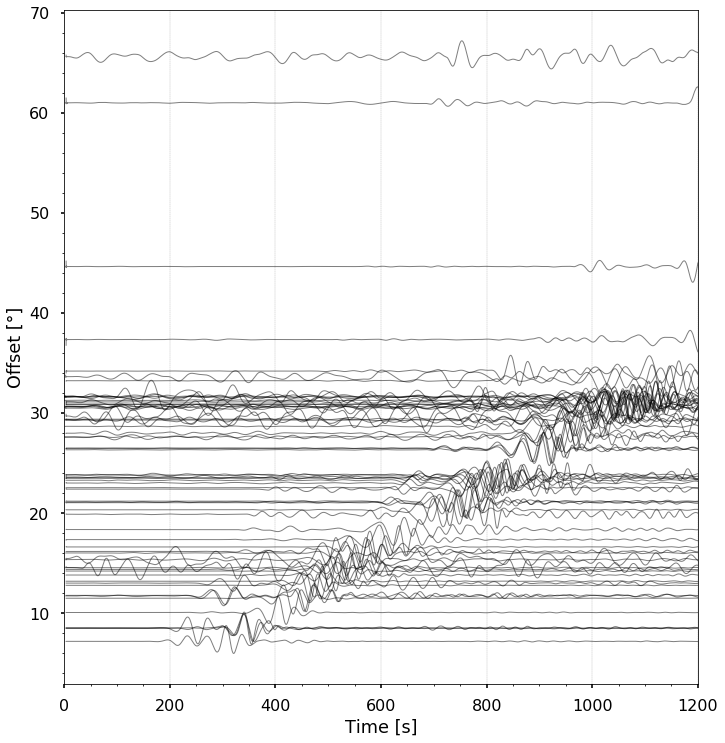

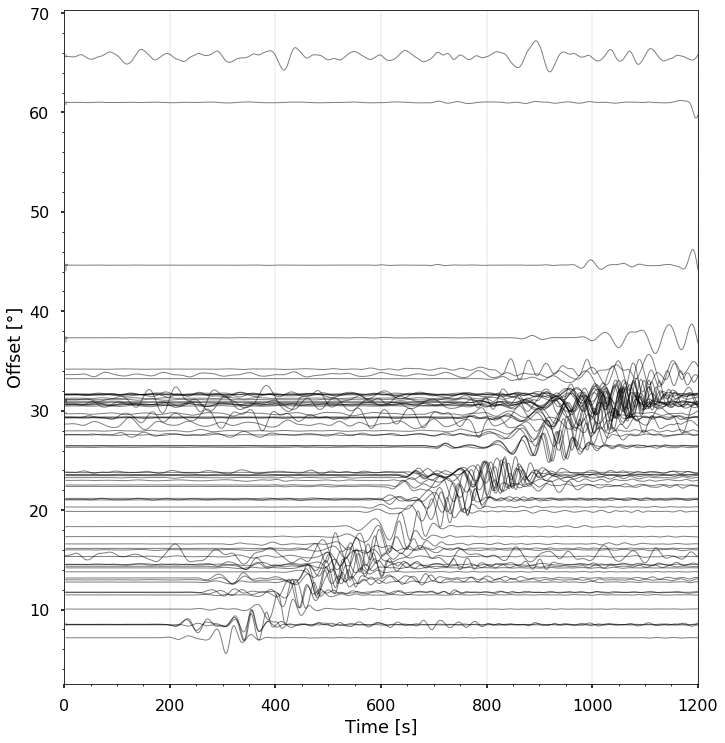

In [12]:
for st  in (st2all.select(channel="*Z"),
            st2all.select(channel="*E"),
            st2all.select(channel="*N") ):
                          
    fig = plt.figure(figsize=(10,12))
    st.plot(type='section', dist_degree=True, recordlength=window_end-window_start, ev_coord=(event_lat,event_lon), scale=3,
             time_down=True, linewidth=1, grid_linewidth=.25, show=False, fig=fig, norm_method='trace', orientation='horizontal')

    plt.show()

In [13]:
# sample_loc1 = "KNRA"
# sample_loc2 = "TOO"


In [14]:
global_amp = 0.0
norm = 0.0

for tr in st2all:
    global_amp += np.abs(tr.max())
    norm += 1.0
    
global_amp /= norm

print("Global amplitude {} ({})".format(global_amp, norm))

scale = 1.0e-4

Global amplitude 0.0004365321047508809 (249.0)


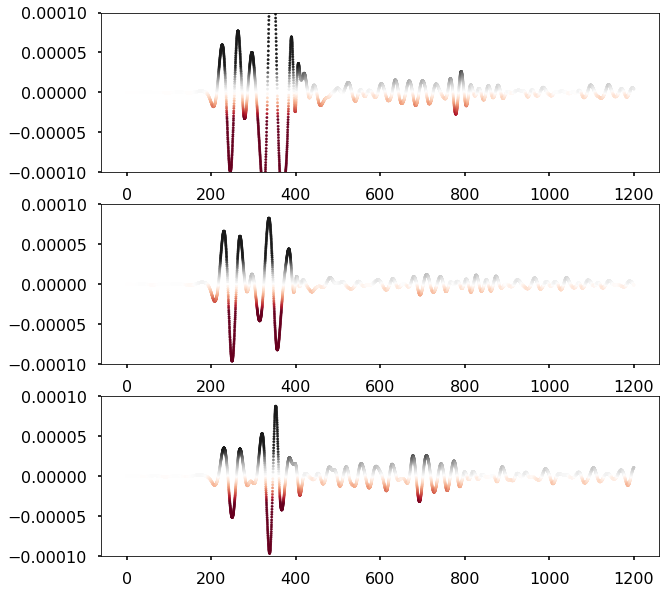

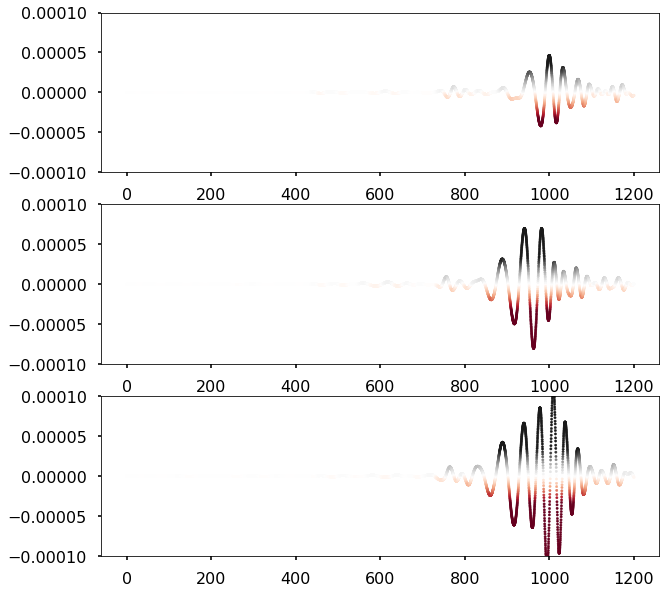

In [15]:
import matplotlib

for id in [ sample_loc1, sample_loc2]:
    ax = ["", "", ""]

    fig = plt.figure(figsize=(10, 10), facecolor="none")
    ax[0] = plt.subplot(311)
    ax[1] = plt.subplot(312)
    ax[2] = plt.subplot(313)

#  trn = st2n.select(station=id)
#  tre = st2e.select(station=id)
#  trz = st2z.select(station=id)

    # print("station:{} @ ({},{})".format(id, trn.meta.coordinates.latitude, trn.meta.coordinates.longitude))

    cmapper= matplotlib.cm.RdGy
    norm   = matplotlib.colors.Normalize(vmin=-scale,vmax=scale)

    for i, chan in enumerate(["*Z", "*E", "*N"]):

        axis = ax[i]
        axis.set_ylim(-scale,scale)
        tr = st2all.select(station=id, channel=chan)[0]  ## Don't care if more than 1 
        times = tr.times()
        delta_time = np.arange(0.0,times.max(),0.2)
        idx = np.searchsorted(times, delta_time, side="left")
        axis.scatter(times[idx], tr.data[idx], c=tr.data[idx], cmap=cmapper, vmin=-scale*0.333, vmax=scale*0.333, s=5)

    plt.show()



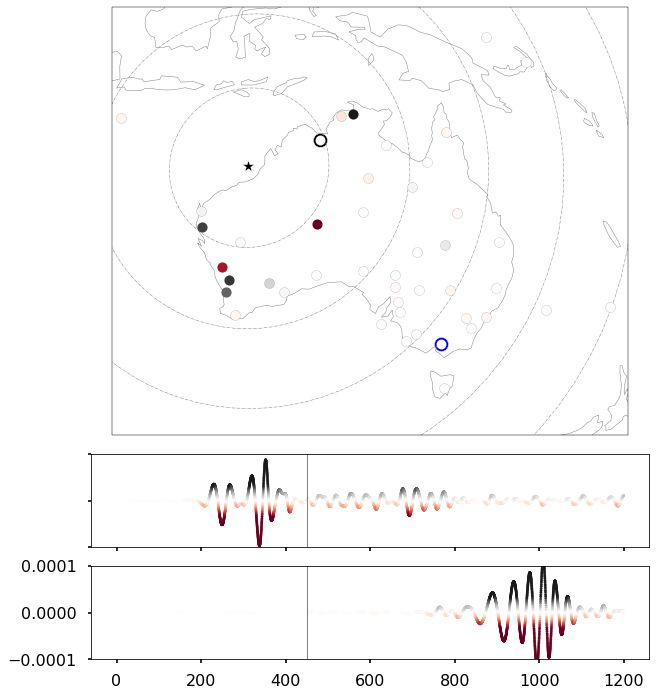

In [16]:
## Trial frame


warnings.filterwarnings("ignore")

def plot_at_time(this_time, stream, sample_no1, sample_no2, scale, savefig=None):
    import matplotlib.gridspec as gridspec

    tr1=stream.select(station=sample_loc1)[0]
    tr2=stream.select(station=sample_loc2)[0]
    
    fig = plt.figure(figsize=(10, 12), facecolor="none")
    gridspec.GridSpec(6,4)
    ax = plt.subplot2grid((6,4), (0,0), colspan=4, rowspan=4, 
                          projection=ccrs.Orthographic(central_longitude=130.0, central_latitude=-30, globe=None))
    
    
    ## Map

    ax.coastlines(color="grey")
    ax.set_extent([105, 165, 2.0, -45])
    
    ax.scatter(event_lon, event_lat, marker="*", s=150, zorder=10,
                color="k", edgecolor="w", transform = ccrs.Geodetic())
    
    ax.scatter(tr1.stats.coordinates.longitude, tr1.stats.coordinates.latitude, s=200, zorder=0,
                color="black", edgecolor="w", transform = ccrs.Geodetic())
    
    ax.scatter(tr2.stats.coordinates.longitude, tr2.stats.coordinates.latitude, s=200, zorder=0,
                color="blue", edgecolor="w", transform = ccrs.Geodetic())
    
    ax.tissot(lons=event_lon, lats=event_lat, rad_km=1000, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )
    ax.tissot(lons=event_lon, lats=event_lat, rad_km=2000, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )
    ax.tissot(lons=event_lon, lats=event_lat, rad_km=3000, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )
    ax.tissot(lons=event_lon, lats=event_lat, rad_km=4000, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )
    ax.tissot(lons=event_lon, lats=event_lat, rad_km=5000, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )

    cmapper= matplotlib.cm.RdGy
    norm   = matplotlib.colors.Normalize(vmin=-scale*0.666,vmax=scale*0.666)
   
    for station in inv_all[0]:
        if len(stream.select(station=station.code))!=0:
            
            trace = stream.select(station=station.code)[0]
            idx   = np.searchsorted(trace.times(), this_time, side="left")
            if idx != len(trace.times()):        
                color = cmapper(norm(trace.data[idx]))
                ax.scatter(station.longitude, station.latitude, marker="o", s=100, zorder=11, 
                             color=color, edgecolor="black", linewidth=0.1, transform = ccrs.Geodetic())

            
    ## Sample trace # 1
    
    ax2 = plt.subplot2grid((6,4), (4,0), colspan=4, rowspan=1)
    ax2.set_ylim(-scale,scale)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    tr = tr1 
    times = tr.times()

    delta_time = np.arange(0.0,times.max(),0.2)
    idx = np.searchsorted(times, delta_time, side="left")
    ax2.scatter(times[idx], tr.data[idx], c=tr.data[idx], cmap=cmapper, s=5, vmin=-scale*0.3333, vmax=scale*0.3333)
    
    ## Draw a line on the trace
    
    ax2.plot([this_time, this_time], [-scale*10.0, scale*10.0], linewidth=0.5, color="black" )
    

    ## Sample trace # 2
    
    ax3 = plt.subplot2grid((6,4), (5,0), colspan=4, rowspan=1)
    ax3.set_ylim(-scale,scale)
    # ax3.set_yticklabels([])

    tr = tr2
    times = tr.times()

    delta_time = np.arange(0.0,times.max(),0.2)
    idx = np.searchsorted(times, delta_time, side="left")
    
    ax3.scatter(times[idx], tr.data[idx], c=tr.data[idx], cmap=cmapper, s=5, vmin=-scale*0.3333, vmax=scale*0.3333)

    ## Draw a line on the trace
    
    ax3.plot([this_time, this_time], [-scale*10.0, scale*10.0], linewidth=0.5, color="black" )
    

    if savefig is not None:
        fig.savefig(savefig)
    else:
        plt.show()
    
    plt.close(fig)


plot_at_time(450.0, st2all.select(channel="*N"), sample_loc1, sample_loc2, scale)


In [17]:
# cmapper= matplotlib.cm.BrBG
# norm   = matplotlib.colors.Normalize(vmin=-scale,vmax=scale)
# signals = st2all.select(channel="*Z")


# import warnings
# warnings.filterwarnings("ignore")

# for i, delta_time in enumerate(np.arange(0.0,window_end-window_start, 1.0)):   
#     if i%10 == 0:
#         print("Plotting frame {} delta t = {}".format(i, delta_time))
#     plot_at_time(delta_time, signals, sample_loc1, sample_loc2, scale, savefig="{}/EQALL.{:04d}.png".format(event_name,i))



In [18]:
def weighted_average_to_nodes(lons, lats, data, interpolator ):
    
    grid   = np.zeros(interpolator.npoints)
    norm   = np.zeros(interpolator.npoints)
    count  = np.zeros(interpolator.npoints, dtype=np.int)

    bcc, nodes = interpolator.containing_simplex_and_bcc(lons, lats)

    # Beware vectorising the reduction operation !!
    
    for i in range(0, len(data)):
        
        grid[nodes[i][0]] += bcc[i][0] * data[i]
        grid[nodes[i][1]] += bcc[i][1] * data[i]
        grid[nodes[i][2]] += bcc[i][2] * data[i]

        norm[nodes[i][0]] += bcc[i][0]
        norm[nodes[i][1]] += bcc[i][1]
        norm[nodes[i][2]] += bcc[i][2]
        
        count[nodes[i][0]] += 1
        count[nodes[i][1]] += 1
        count[nodes[i][2]] += 1
        
    norm[np.where(norm <=1.0e-12)] = 0.0
    grid[np.where(norm != 0.0)] /= norm[np.where(norm != 0.0)]
   
    return grid, norm, count

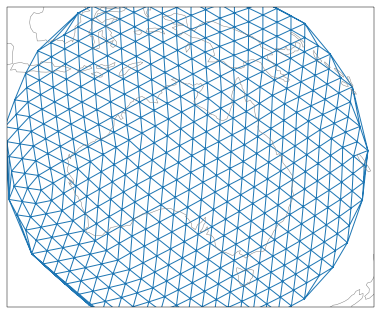

In [19]:
import stripy
# import importlib
# importlib.reload(stripy)

## Define starting grid
grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=True,  refinement_levels=4, tree=True)

# Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(134.0) * np.ones_like(grid1r.lons), 
                                    np.radians(-24.0) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(30))
grid1 = stripy.sTriangulation(grid1r.lons_map_to_wrapped(grid1r.lons[nodes])%(2.0*np.pi), grid1r.lats[nodes], permute=True, refinement_levels=0)

llo, lla = grid1.uniformly_refine_triangulation(faces=True)
grid1f = stripy.sTriangulation(llo, lla)




# pts_lat=[]
# pts_lon=[]

# for station in inv_all[0]:
#     pts_lat.append(station.latitude)
#     pts_lon.append(station.longitude)
    
# lons = np.array(pts_lon)
# lats = np.array(pts_lat)

# lons_r = np.radians(lons)
# lats_r = np.radians(pts_lat)
    
# gridded, norm, count = weighted_average_to_nodes(lons_r, lats_r, np.ones_like(lons_r), grid1)

# nodes = np.where(count != 0)

# grid2 = stripy.sTriangulation(grid1.lons_map_to_wrapped(grid1.lons[nodes])%(2.0*np.pi), grid1.lats[nodes], permute=True, refinement_levels=0)

grid2 = grid1 # over-ride if dropping points

fig = plt.figure(figsize=(10, 12), facecolor="none")
matplotlib.gridspec.GridSpec(6,4)
ax1 = plt.subplot2grid((6,6), (0,0), colspan=4, rowspan=4, 
                        projection=ccrs.Orthographic(central_longitude=134.0, central_latitude=-24, globe=None))

ax1.coastlines(color="grey")
ax1.set_extent([105, 165, 2.0, -45])
ax1.triplot(np.degrees(grid2.lons), np.degrees(grid2.lats), grid2.simplices, linewidth=1.0,
               transform=ccrs.PlateCarree(), alpha=1.0)


In [20]:
stream = st2all.select(channel="*N")
this_time = 1.0

pts_lat=[]
pts_lon=[]
pts_val=[]

for station in inv_all[0]:
    if len(stream.select(station=station.code))!=0:

        trace = stream.select(station=station.code)[0]
        idx   = np.searchsorted(trace.times(), this_time, side="left")
        if idx != len(trace.times()):   
            pts_lat.append(station.latitude)
            pts_lon.append(station.longitude)

            if not np.isnan(float(trace.data[idx])):
                pts_val.append(float(trace.data[idx]))
            else:
                pts_val.append(0.0)

lons = np.array(pts_lon)
lats = np.array(pts_lat)

lons_r = np.radians(lons)
lats_r = np.radians(pts_lat)

vals  = np.array(pts_val)
vals1 = np.clip(vals, -scale, scale)

gridded1, norm, count = weighted_average_to_nodes(lons_r, lats_r, vals1, grid2 )
gridded  = np.clip(gridded1, -scale, scale)
rms = np.sqrt((gridded**2).mean())

sm = 10000.0
err = 1
while err:
    smooth, deriv, err = grid2.smoothing(gridded, 1e8 * (1e-8+norm) , sm * rms**2 , 0.5, 0.01)
    if err:
        sm *= 0.1
    else:
        print("sm = {:.2}".format(sm))


sm = 1e+04


In [21]:
scale=1.0e-4

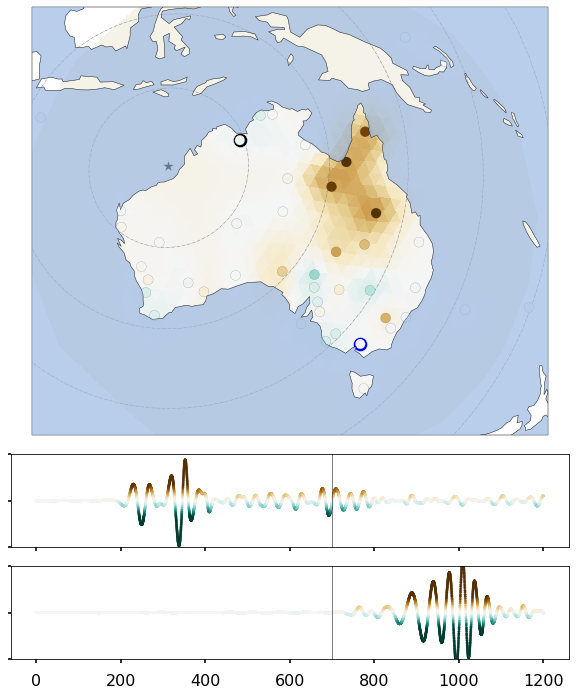

In [29]:
def surface_plot_at_time(this_time, stream, sample_no1, sample_no2, scale, savefig=None):
    import matplotlib.gridspec as gridspec

    tr1=stream.select(station=sample_loc1)[0]
    tr2=stream.select(station=sample_loc2)[0]
    
    fig = plt.figure(figsize=(10, 12), facecolor="none")
    gridspec.GridSpec(6,4)
    ax = plt.subplot2grid((6,4), (0,0), colspan=4, rowspan=4, 
                          projection=ccrs.Orthographic(central_longitude=130.0, central_latitude=-30, globe=None))
      
    ## Map

    ax.coastlines(color="grey")
    ax.set_extent([105, 165, 2.0, -45])
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        
        ax.scatter(event_lon, event_lat, marker="*", s=150, zorder=10,
                    color="k", edgecolor="w", transform = ccrs.Geodetic())
        ax.scatter(tr1.stats.coordinates.longitude, tr1.stats.coordinates.latitude, s=200, zorder=9, marker='o',
                    color="black", edgecolor="w", transform = ccrs.Geodetic())
        ax.scatter(tr2.stats.coordinates.longitude, tr2.stats.coordinates.latitude, s=200, zorder=9, marker='o',
                    color="blue", edgecolor="w", transform = ccrs.Geodetic())
    
    for radius in (1000,2000,3000,4000,5000):
        ax.tissot(lons=event_lon, lats=event_lat, rad_km=radius, edgecolor="grey", facecolor="none", linewidth=0.5, linestyle="-." )

    cmapper= matplotlib.cm.BrBG_r
    norm   = matplotlib.colors.Normalize(vmin=-scale*0.666,vmax=scale*0.666)
   
    pts_lat=[]
    pts_lon=[]
    pts_val=[]

    for station in inv_all[0]:
        if len(stream.select(station=station.code))!=0:
            
            trace = stream.select(station=station.code)[0]
            idx   = np.searchsorted(trace.times(), this_time, side="left")
            if idx != len(trace.times()):   
                pts_lat.append(station.latitude)
                pts_lon.append(station.longitude)
                
                if not np.isnan(float(trace.data[idx])):
                    pts_val.append(float(trace.data[idx]))
                else:
                    pts_val.append(0.0)
             
    lons = np.array(pts_lon)
    lats = np.array(pts_lat)

    lons_r = np.radians(lons)
    lats_r = np.radians(pts_lat)
    
    vals  = np.array(pts_val)
    vals1 = np.clip(vals, -scale, scale)
    
    gridded1, norm, count = weighted_average_to_nodes(lons_r, lats_r, vals1, grid2 )
    gridded  = np.clip(gridded1, -scale*10, scale*10)
    
    rms = np.sqrt((gridded**2).mean())
    
    sm = 1000.
    with warnings.catch_warnings():
        warnings.filterwarnings("always")
        smooth, deriv, err = grid2.smoothing(gridded1, 1.e5 * (1.e-5+norm) , sm * rms**2 , 0.15, 0.01)
        if err:
            print("smoothing error {}".format(err))

#     err = 1
#     while err:
#         smooth, deriv, err = grid2.smoothing(gridded1, 1.e5 * (1.e-5+norm) , sm * rms**2 , 0.15, 0.01)
#         if err or sm < 1.0e-6:
#             sm *= 0.1
#         else:
#             print("sm = {:.2} = smooth.min={} / smooth.max={}".format(sm, smooth.min(), smooth.max()))
#             print("sm = {:.2} = gridded1.min={} / gridded1.max={}".format(sm, gridded1.min(), gridded1.max()))
            

    
    smooth1f, err = grid2.interpolate(grid1f.lons, grid1f.lats, smooth, order=3)
                    
#     ax.tricontourf(np.degrees(grid2.lons), np.degrees(grid2.lats), grid2.simplices, smooth, zorder=1,  extend="both",
#                  levels=50,  transform=ccrs.PlateCarree(), alpha=1.0, cmap=cmapper, vmin=-scale*2.0, vmax=scale*2.0)
    
    ax.tripcolor(np.degrees(grid1f.lons), np.degrees(grid1f.lats), grid1f.simplices, smooth1f, zorder=1,
                 transform=ccrs.PlateCarree(), alpha=1.0, cmap=cmapper, vmin=-scale*2.0, vmax=scale*2.0)
    
    
    
    ax.scatter(lons, lats, marker="o", s=100, c=vals, zorder=11, cmap=cmapper, vmin=-scale, vmax=scale,
               edgecolor="black", linewidth=0.1, transform = ccrs.Geodetic())
    ax.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k', alpha=0.666)



    ## Sample trace # 1
    
    ax2 = plt.subplot2grid((6,4), (4,0), colspan=4, rowspan=1)
    ax2.set_ylim(-scale,scale)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    tr = tr1 
    times = tr.times()

    delta_time = np.arange(0.0,times.max(),0.2)
    idx = np.searchsorted(times, delta_time, side="left")
    ax2.scatter(times[idx], tr.data[idx], c=tr.data[idx], cmap=cmapper, s=5, vmin=-scale*0.3333, vmax=scale*0.3333)
    
    ## Draw a line on the trace
    
    ax2.plot([this_time, this_time], [-scale*10.0, scale*10.0], linewidth=0.5, color="black" )
    
    ## Sample trace # 2
    
    ax3 = plt.subplot2grid((6,4), (5,0), colspan=4, rowspan=1)
    ax3.set_ylim(-scale,scale)
    ax3.set_yticklabels([])

    tr = tr2
    times = tr.times()

    delta_time = np.arange(0.0,times.max(),0.2)
    idx = np.searchsorted(times, delta_time, side="left")
    
    ax3.scatter(times[idx], tr.data[idx], c=tr.data[idx], cmap=cmapper, s=5, vmin=-scale*0.3333, vmax=scale*0.3333)

    ## Draw a line on the trace
    
    ax3.plot([this_time, this_time], [-scale*10.0, scale*10.0], linewidth=0.5, color="black" )
    

    if savefig is not None:
        fig.savefig(savefig)
    else:
        plt.show()

    plt.close(fig)
    
    return 


surface_plot_at_time(700.0, st2all.select(channel="*N"), sample_loc1, sample_loc2, scale)

In [23]:

cmapper= matplotlib.cm.BrBG
norm   = matplotlib.colors.Normalize(vmin=-scale,vmax=scale)
signals = st2all.select(channel="*N")

import warnings

for i, delta_time in enumerate(np.arange(100.0,1100.0, 1.0)):   
    if i%10 == 0:
        print("Plotting frame {} delta t = {}".format(i, delta_time))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        surface_plot_at_time(delta_time, signals, sample_loc1, sample_loc2, scale, savefig="{}/EQALL-NL.{:04d}.png".format(event_name,i))



Plotting frame 0 delta t = 100.0
Plotting frame 10 delta t = 110.0
Plotting frame 20 delta t = 120.0
Plotting frame 30 delta t = 130.0
Plotting frame 40 delta t = 140.0
Plotting frame 50 delta t = 150.0
Plotting frame 60 delta t = 160.0
Plotting frame 70 delta t = 170.0
Plotting frame 80 delta t = 180.0
Plotting frame 90 delta t = 190.0
Plotting frame 100 delta t = 200.0
Plotting frame 110 delta t = 210.0
Plotting frame 120 delta t = 220.0
Plotting frame 130 delta t = 230.0
Plotting frame 140 delta t = 240.0
Plotting frame 150 delta t = 250.0
Plotting frame 160 delta t = 260.0
Plotting frame 170 delta t = 270.0
Plotting frame 180 delta t = 280.0
Plotting frame 190 delta t = 290.0
Plotting frame 200 delta t = 300.0
Plotting frame 210 delta t = 310.0
Plotting frame 220 delta t = 320.0
Plotting frame 230 delta t = 330.0
Plotting frame 240 delta t = 340.0
Plotting frame 250 delta t = 350.0
Plotting frame 260 delta t = 360.0
Plotting frame 270 delta t = 370.0
Plotting frame 280 delta t = 38

In [24]:
import os
import imageio

path = event_name

fileList = []
for file in sorted(os.listdir(path)):
    if "EQALL-NL" in file:
        full_path = os.path.join(path,file)
        fileList.append(full_path)

writer = imageio.get_writer('{}-ALL-N.mp4'.format(event_name), fps=50)

for im in fileList:
    writer.append_data(imageio.imread(im))
    
writer.close()



NameError: name 'areas' is not defined